In [ ]:
### PSI Prediction in Singapore
### Zahra Ebrahimi 07/26/2020
### YapAiTek-Assessment

In [2]:
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [4]:
psi_df = pd.read_csv('./PSI/psi_df_2016_2019.csv')
psi_df.head(3)

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00


In [5]:
#Convert 'timestamp' column to date/time type
#Use temporary dataframe for making a datetime column
#Make datetime column

columns_names = psi_df.keys().values.tolist()
psi_df['year'] = psi_df['timestamp'].str[0:4].astype(int)
psi_df['month'] = psi_df['timestamp'].str[5:7].astype(int)
psi_df['day'] = psi_df['timestamp'].str[8:10].astype(int)
psi_df['hour'] = psi_df['timestamp'].str[11:13].astype(int)
psi_df['minute'] = psi_df['timestamp'].str[14:16].astype(int)
psi_df['second'] = psi_df['timestamp'].str[17:19].astype(int)


temp_datetime_df = psi_df.drop(columns=columns_names)  
psi_df['datetime'] = pd.to_datetime(temp_datetime_df) 

temp_columns=['timestamp','year','month','day', 'hour','minute','second']
psi_df = psi_df.drop(columns=temp_columns)
print('Min : {}, Max : {}'.format(min(psi_df.datetime), max(psi_df.datetime)))

Min : 2016-02-07 18:00:00, Max : 2019-11-06 14:00:00


In [6]:
psi_df.describe()

,national,south,north,east,central,west
count,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000
mean,50.502232,54.294351,54.003464,52.491007,52.885884,50.299014
std,13.107219,10.844489,10.991413,10.365553,11.832203,11.672157
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000


In [12]:
psi_df= psi_df.set_index("datetime") # set 'datetime' column for better management of time series 
psi_df.head(3)

,national,south,north,east,central,west
datetime,,,,,,
2016-02-07 18:00:00,47,44,37,47,47,34
2016-02-08 23:00:00,59,57,54,59,57,56
2016-02-09 01:00:00,59,57,55,59,57,56


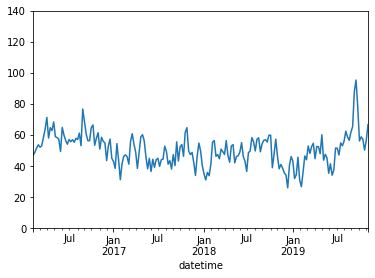

In [14]:
psi_week=psi_df['2016':].resample('w').mean().national # resample by 'national' column week to week data
psi_week.plot(ylim=[0,140])

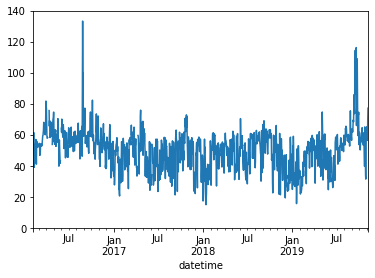

In [17]:
psi_day=psi_df['2016':].resample('D').mean().national # resample by 'national' column day to day data
psi_day.plot(ylim=[0,140])

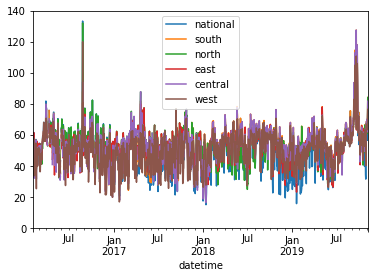

In [18]:
psi_day_all=psi_df['2016':].resample('D').mean() # resample by all columns day to day data
psi_day_all.plot(ylim=[0,140])

In [19]:
psi_day_all= psi_day_all.dropna()
psi_day_all.isnull().sum()

national    0
south       0
north       0
east        0
central     0
west        0
dtype: int64

In [20]:
# Making model based on 4 days prediction just for 'national' column
# You can use any other column base on your priority
train_data= psi_day_all
X_length = 4 
X_y = np.zeros((train_data.shape[0] - X_length, X_length + 1))
for i in range(X_y.shape[0]):
    X_y[i, :] = train_data['national'].to_numpy()[i:i + X_length + 1]

In [21]:
# Split train and test sets
test_ratio = 0.2
indices = np.arange(start=0, stop=X_y.shape[0])
test_set_size = int(X_y.shape[0] * test_ratio)
train_index = np.sort(indices[:-test_set_size])
test_index = np.sort(indices[-test_set_size:])

train_data = X_y[train_index, :]
test_data = X_y[test_index, :]

print(train_data.shape[0], "train +", test_data.shape[0], "test")

# np.save('./PSI/train_data', train_data)
# np.save('./PSI/test_data', test_data)
y_train = train_data[:, -1]
X_train = train_data[:, :-1]

1081 train + 270 test


In [22]:
# All training data is used to set Min and Max Parameters

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data.reshape(-1, 1))  
X_train_normalized = scaler.transform(X_train)
y_train_normalized = scaler.transform(y_train.reshape(-1, 1))

In [23]:
# Split train and validation sets
np.random.seed(123)
val_ratio = 0.1
indices = np.random.permutation(X_train_normalized.shape[0])
val_set_size = int(X_train_normalized.shape[0] * val_ratio)
train_indices = np.sort(indices[:-val_set_size])
val_indices = np.sort(indices[-val_set_size:])

X_val = X_train_normalized[val_indices, :]
y_val = y_train_normalized[val_indices, :]
X_train = X_train_normalized[train_indices, :]
y_train = y_train_normalized[train_indices, :]

In [24]:
n_steps = 4
# reshape from [samples, timesteps] into [samples, timesteps, features] to make 3 dimentions 
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [63]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(30, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 60)                7680      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 7,741
Trainable params: 7,741
Non-trainable params: 0
_________________________________________________________________


In [65]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 32
epochs = 100
# train the model using the training set and validating using validation set
history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),callbacks=[tensorboard, early_stopping])

Epoch 1/100
31/31 [==============================] - 1s 18ms/step - loss: 0.1288 - val_loss: 0.0513
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0347 - val_loss: 0.0250
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0260 - val_loss: 0.0222
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0246 - val_loss: 0.0217
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0238 - val_loss: 0.0213
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0229 - val_loss: 0.0209
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0205
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0205
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.0202
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 11

Text(0, 0.5, 'MSE Loss')

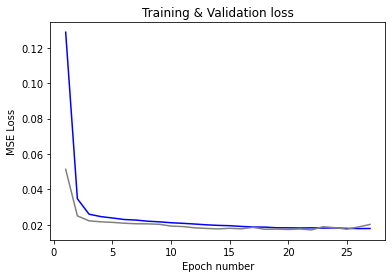

In [66]:
#Plot Training & Validation loss
history_dict=history.history
loss_values= history_dict['loss']
val_loss_values= history_dict['val_loss']
epochss= range(1, len(loss_values)+1)

plt.plot(epochss , loss_values, 'b' , label= 'Training loss')
plt.plot(epochss , val_loss_values, 'grey' , label= 'Validation loss')
plt.title('Training & Validation loss')

plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')

In [67]:
# preparing Data and Label for test set
# Normalize test set with Scaler fitted with train data
# demonstrate prediction

y_test = test_data[:, -1]
X_test = test_data[:, :-1]

X_test_normalized = scaler.transform(X_test)
y_test_normalized = scaler.transform(y_test.reshape(-1, 1))

y_pred = np.zeros_like(y_test_normalized)

x_input = X_test_normalized.reshape((X_test_normalized.shape[0], n_steps, n_features))
y_pred = model.predict(x_input, verbose=0)

err = y_test_normalized - y_pred
# Root Mean Square Error
RMSE = np.sqrt(np.mean(np.power(err, 2)))
RMSE

0.14591769955922781

In [68]:
#Function to prepare and test a new sample
def predict_psi_level(X, model, scaler):
    # Normalize test set with Scaler fitted with train data
    X_normalized = scaler.transform(X.reshape(-1, 1))
    # Reshape matrix to 3 dimentions data
    x_input = X_normalized.reshape(1, n_steps, n_features)
    # Prediction
    prediction_normalized = model.predict(x_input, verbose=0) 
    # Inverse of Normalization
    prediction = np.squeeze(scaler.inverse_transform(prediction_normalized.reshape(-1, 1)))
    psi_bands = np.array([0., 56., 150., 250])
    psi_levels = ['Normal', 'Elevated', 'High', 'Very high']
    return psi_levels[np.argwhere(prediction >= psi_bands)[-1][0]]

In [69]:
i_sample = 5
X = test_data[i_sample, :-1]

PSI_level = predict_psi_level(X, model, scaler)
PSI_level

'Normal'